<a href="https://colab.research.google.com/github/pricoptudor/ATNN_PricopTudor/blob/main/Lab04/Solution/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import torch
import random
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, RandomHorizontalFlip, ToTensor, Normalize, RandomAdjustSharpness, ColorJitter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
report = SummaryWriter()

In [ ]:
def get_time(filename):
    start_index = filename.index("global_monthly_") + len("global_monthly_")
    end_index = filename.index("_mosaic")
    year = int(filename[start_index:start_index+4])
    month = int(filename[start_index+5:end_index])
    return datetime.datetime(year, month, 1)

In [ ]:
transform = Compose([
    ToTensor(),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Normalize(0.0006, 0.0011), # normalizing ruins the images
    RandomHorizontalFlip(p=0.5),
    RandomAdjustSharpness(0.5)
])

In [ ]:
# caches the dataset in memory
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.samples = []

        for location in os.listdir(folder_path):
            location_path = os.path.join(folder_path, location, 'images')

            location_images = []
            for filename in os.listdir(location_path):
                image_path = os.path.join(location_path, filename)
                image = Image.open(image_path)
                location_images.append((image, get_time(filename)))
            sorted_location_images = sorted(location_images, key=lambda x: x[1].year)

            for i in range(len(sorted_location_images) - 1):
                for j in range(i+1, len(sorted_location_images)):
                    start_image, start_datetime = sorted_location_images[i]
                    end_image, end_datetime = sorted_location_images[j]
                    time_skip = (end_datetime.year - start_datetime.year) * 12 + (end_datetime.month - start_datetime.month)
                    if self.transform:
                        self.samples.append((self.transform(start_image), self.transform(end_image), time_skip))
                    else:
                        self.samples.append((start_image, end_image, time_skip))

                    # Random rotation augmentation
                    angle = random.uniform(-90, 90)
                    if self.transform:
                        self.samples.append((self.transform(start_image.rotate(angle)), self.transform(end_image.rotate(angle)), time_skip))
                    else:
                        self.samples.append((start_image.rotate(angle), end_image.rotate(angle), time_skip))

    def __len__(self):
        return len(self.samples)

    @lru_cache(maxsize=None)
    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
dataset = ImageDataset(folder_path='../Homework Dataset/', transform=transform)

In [ ]:
# check image shape
print(dataset[0][0].shape)

torch.Size([3, 128, 128])


In [ ]:
# check image pixels range (0-255)
image = Image.open('../Homework Dataset/L15-0595E-1278N_2383_3079_13/images/global_monthly_2018_01_mosaic_L15-0595E-1278N_2383_3079_13.tif')

array = np.array(image)

print(f'Minimum pixel value: {array.min()}')
print(f'Maximum pixel value: {array.max()}')

Minimum pixel value: 22
Maximum pixel value: 255


In [ ]:
for location in os.listdir('../Homework Dataset/'):
    location_path = os.path.join('../Homework Dataset/', location, 'images')

    location_images = []
    for filename in os.listdir(location_path):
        image_path = os.path.join(location_path, filename)
        image = Image.open(image_path)
        location_images.append(ToTensor()(image))

print(f'Before scaling: {torch.std_mean(torch.stack(location_images).float())}')
print(f'After scaling: {torch.std_mean(torch.stack(location_images).float() / 255)}')

Before scaling: (tensor(0.1489), tensor(0.2887))
After scaling: (tensor(0.0006), tensor(0.0011))


In [ ]:
# Split dataset: train, validation, test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
for start, end, time in train_loader:
    print(f'Start: {start.shape}, End: {end.shape}, Time: {time}')
    break
for start, end, time in val_loader:
    print(f'Start: {start.shape}, End: {end.shape}, Time: {time}')
    break
for start, end, time in test_loader:
    print(f'Start: {start.shape}, End: {end.shape}, Time: {time}')
    break

Start: torch.Size([32, 3, 128, 128]), End: torch.Size([32, 3, 128, 128]), Time: tensor([10,  2,  6, 24,  7,  6, 20,  5, 15, 16, 15,  5,  3,  7,  3, 10,  5,  5,
         6, 12,  6,  7,  1,  4, 11,  8, 14, 10,  4,  7,  1, 16])
Start: torch.Size([32, 3, 128, 128]), End: torch.Size([32, 3, 128, 128]), Time: tensor([ 5, 22, 17,  6, 21, 16, 14, 15, 12,  3, 14, 16, 15, 19,  1, 19,  6, 14,
         9,  7,  1,  7, 11,  2, 10,  4, 16,  1, 21,  1,  9,  3])
Start: torch.Size([32, 3, 128, 128]), End: torch.Size([32, 3, 128, 128]), Time: tensor([ 6,  7,  9,  6,  8,  1, 15, 18,  8, 14,  8, 21,  7, 17,  6,  4,  3,  5,
         2,  3, 11, 11,  3, 12, 16,  6, 13, 16,  2,  3,  5,  8])


In [ ]:
# accuracy is not a suitable metric for predicting the future state of an image

In [ ]:
class Pipeline:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, train_loader):
        self.model.train()
        running_loss = 0.0

        for inputs, labels, times in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            times = times.to(device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs, times)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        return epoch_loss

    def val(self, val_loader):
        self.model.eval()
        running_loss = 0.0

        for inputs, labels, times in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            times = times.to(device)

            with torch.no_grad():
                outputs = self.model(inputs, times)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(val_loader.dataset)
        return epoch_loss

    def test(self, test_loader):
        self.model.eval()
        running_loss = 0.0

        for inputs, labels, times in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            times = times.to(device)

            with torch.no_grad():
                outputs = self.model(inputs, times)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_loader.dataset)
        return epoch_loss

    def run(self, epochs, train_loader, val_loader, test_loader):
        train_losses = []
        val_losses = []
        test_losses = []
        for epoch in range(epochs):
            train_loss = self.train(train_loader)
            val_loss = self.val(val_loader)
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            report.add_scalar('Train loss', train_loss, epoch)
            report.add_scalar('Test loss', val_loss, epoch)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

        test_loss = self.test(test_loader)
        print(f'Test Loss: {test_loss:.4f}')
        report.add_scalar('Test loss', test_loss, epochs)
        test_losses.append(test_loss)

        return train_losses, val_losses, test_losses

In [ ]:
report.close()

#### Call `tensorboard --logdir=.`

In [ ]:
from torch.nn import Conv2d, Linear, MaxPool2d, Module, MSELoss
from torch.nn.functional import relu, sigmoid
from torch.optim import Adam

In [ ]:
class Network(Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = Conv2d(3, 8, 3, padding=1)
        self.pool = MaxPool2d(2)
        self.conv2 = Conv2d(8, 16, 3, padding=1)
        self.fc1 = Linear(16 * 32 * 32 + 1, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 128*128*3)

    def forward(self, x, time):
        x_identity = x.clone()
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        time = time.unsqueeze(1)
        x = torch.cat((x, time), dim=1)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size(0), 3, 128, 128)
        x += x_identity
        return x

In [ ]:
model = Network()
model.to(device)

Network(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16385, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=49152, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
criterion = MSELoss()
criterion.to(device)

MSELoss()

In [ ]:
pipeline = Pipeline(model=model, optimizer=optimizer, criterion=criterion)

In [ ]:
train_losses, val_losses, test_losses = pipeline.run(epochs=10, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

Epoch 1/10, Train Loss: 0.0319, Val Loss: 0.0304
Epoch 2/10, Train Loss: 0.0293, Val Loss: 0.0289
Epoch 3/10, Train Loss: 0.0281, Val Loss: 0.0284
Epoch 4/10, Train Loss: 0.0273, Val Loss: 0.0281
Epoch 5/10, Train Loss: 0.0266, Val Loss: 0.0279
Epoch 6/10, Train Loss: 0.0259, Val Loss: 0.0275
Epoch 7/10, Train Loss: 0.0254, Val Loss: 0.0278
Epoch 8/10, Train Loss: 0.0250, Val Loss: 0.0280
Epoch 9/10, Train Loss: 0.0246, Val Loss: 0.0281
Epoch 10/10, Train Loss: 0.0241, Val Loss: 0.0276
Test Loss: 0.0276


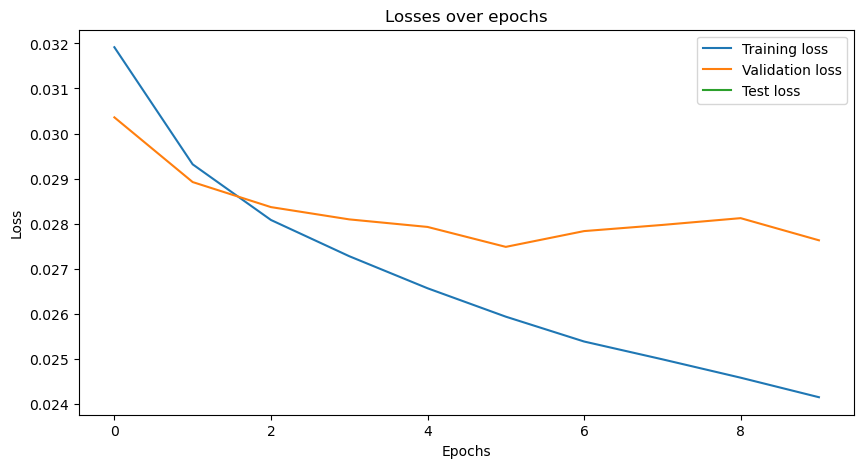

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(test_losses, label='Test loss')
plt.title('Losses over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [ ]:
start, end, time = train_loader.dataset[0]
start, end, time

(tensor([[[0.4961, 0.5247, 0.5509,  ..., 0.4407, 0.6289, 0.5033],
          [0.4962, 0.4924, 0.5424,  ..., 0.4497, 0.6882, 0.4822],
          [0.4996, 0.5168, 0.5303,  ..., 0.5586, 0.6717, 0.4867],
          ...,
          [0.4873, 0.4290, 0.4542,  ..., 0.4130, 0.3847, 0.3927],
          [0.4626, 0.5118, 0.4915,  ..., 0.3980, 0.3715, 0.4266],
          [0.4522, 0.4260, 0.4746,  ..., 0.4058, 0.4062, 0.3765]],
 
         [[0.4703, 0.4977, 0.5117,  ..., 0.4314, 0.6152, 0.4888],
          [0.4587, 0.4602, 0.5080,  ..., 0.4326, 0.6563, 0.4737],
          [0.4786, 0.4915, 0.4941,  ..., 0.5276, 0.6446, 0.4734],
          ...,
          [0.4727, 0.4248, 0.4457,  ..., 0.4106, 0.3772, 0.3834],
          [0.4494, 0.4943, 0.4688,  ..., 0.3744, 0.3665, 0.4133],
          [0.4533, 0.4279, 0.4614,  ..., 0.3922, 0.3860, 0.3655]],
 
         [[0.2390, 0.2582, 0.2653,  ..., 0.2170, 0.3385, 0.2415],
          [0.2582, 0.2401, 0.2568,  ..., 0.2212, 0.3692, 0.2299],
          [0.2426, 0.2455, 0.2495,  ...,

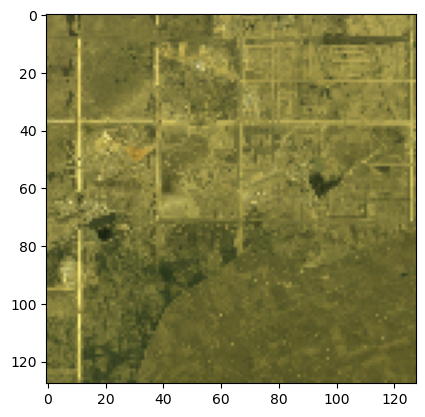

In [ ]:
import torchvision.transforms as transforms

image_transform = transforms.ToPILImage()

# tensor(0.0006), tensor(0.0011)
start_image = image_transform(start)

plt.imshow(start_image)
plt.show()

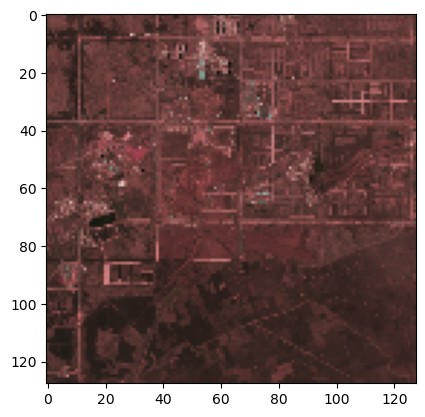

In [ ]:
end_image = image_transform(end)

plt.imshow(end_image)
plt.show()

In [ ]:
start.unsqueeze(0).shape, torch.Tensor([time]).shape

(torch.Size([1, 3, 128, 128]), torch.Size([1]))

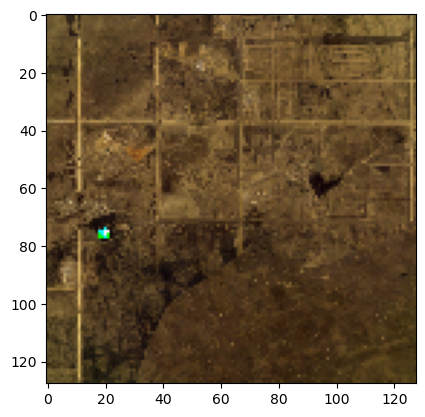

In [ ]:
output = model(start.unsqueeze(0), torch.Tensor([time]))
output_image = image_transform(output.squeeze(0))

plt.imshow(output_image)
plt.show()